# 期末大作业 参考模板

**仅供参考，不强制使用该模板写法**

In [1]:
import os
import torch
import cv2
import random
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 数据读取与预处理

In [113]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info.head(5)

,name,intro
id,,
1,Toy Story (1995),A cowboy doll is profoundly threatened and jea...
2,Jumanji (1995),When two kids find and play a magical board ga...
3,Grumpier Old Men (1995),John and Max resolve to save their beloved bai...
4,Waiting to Exhale (1995),"Based on Terry McMillan's novel, this film fol..."
5,Father of the Bride Part II (1995),George Banks must deal not only with the pregn...


In [114]:
def preprocess_intro(
    all_intros: List[str]
) -> List[str]:
    
    processed = []
    for raw_intro in all_intros:
        
        # Do something to raw_intro
        intro = raw_intro

        processed.append(intro)
    return processed

In [115]:
movie_intros = preprocess_intro(df_movie_info.loc[:, 'intro'].tolist())
movie_names = df_movie_info.loc[:, 'name'].tolist()

Sabrina (1995) 
An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused brother has something to say about it.


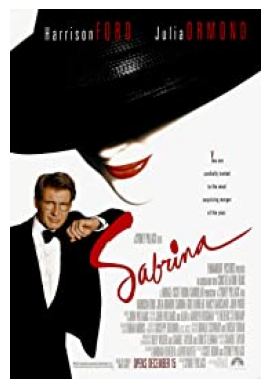

In [116]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

poster = cv2.imread(f'./poster/{all_posters_filename[index_for_test]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()

## 训练集划分

In [117]:
with open('train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

# Here elements in posters_train and posters_test are actually filenames, not vectors
print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


## 搭建pytorch数据集

以下只是一种可能的写法
- 如果之前已经完成了对海报和简介数据的预处理工作，那么就可以不需要这里的`process_poster`和`process_intro`函数
- 如果之前已经将海报数据全部读入，那么就无需再在`Dataset`类中写一次读取图片的操作（对于小数据集可以这样做，但是对于大型的数据集，全部读进来通常是存不下的，因此更推荐在继承的`Dataset`或者`DataLoader`中实现按需读取和预处理）
- ......

In [118]:
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
    
    def __len__(self):
        return len(self.posters)
    
    def process_poster(self, path, **kwargs):
        poster = cv2.imread(path)
        # Do something to poster ...
        poster_processed = poster

        return poster_processed
    
    def process_intro(self, intro, **kwargs):
        # Do something to intro ...
        intro_processed = intro

        return intro_processed
    
    def __getitem__(self, index):
        
        poster = self.encode_poster(
            os.path.join(self.data_root, self.posters[index])
        )
        intro = self.encode_intro(
            self.intros[index]
        )

        return poster, intro, # maybe you want to return more than these


data_root = './poster'
dataset_train = MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
)

In [119]:
train_dataloader = DataLoader(dataset_train, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=1)

## 定义模型

In [120]:
class MyModel(torch.nn.Module):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__()
        pass

    def forward(self, x):
        pass
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_args = {}
my_model = MyModel(**model_args).to(device)

## 模型训练

In [121]:
# Train your model

## 模型测试

In [122]:
def get_dist_matrix(model, dataloader, **kwargs):
    model.eval()

    N = ...
    distances = torch.zeros((N, N))
    
    with torch.no_grad():
        # Get distances of all poster-intro pair
        pass
    
    return distances

In [ ]:
D_test = get_dist_matrix(my_model, test_dataloader)

In [ ]:
def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
    accuracy = correct_matches / total_samples
    return accuracy


In [ ]:
accuracy = get_acc(D_test, ratio=0.05, dim=0)
print(f'Accuracy on dim 0: {accuracy * 100:.2f}%')
accuracy = get_acc(D_test, ratio=0.05, dim=1)
print(f'Accuracy on dim 1: {accuracy * 100:.2f}%')